### IMPORTING THE REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### IMPORTING THE DATASET

In [2]:
dataset = pd.read_csv("real_estate_price_size_year_view.csv") #100 records
print(dataset.head(10))
X = dataset.iloc[:, [1, 2, 3]]  # size, year, view
y = dataset.iloc[:, 0]          # price

        price     size  year         view
0  234314.144   643.09  2015  No sea view
1  228581.528   656.22  2009  No sea view
2  281626.336   487.29  2018     Sea view
3  401255.608  1504.75  2015  No sea view
4  458674.256  1275.46  2009     Sea view
5  245050.280   575.19  2006     Sea view
6  265129.064   570.89  2015     Sea view
7  175716.480   620.82  2006  No sea view
8  331101.344   682.26  2018     Sea view
9  218630.608   694.52  2009  No sea view


### ENCODING THE CATEGORICAL VARIABLES USING ONE HOT ENCODER

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer(
    transformers=[
        ('view_encoder', OneHotEncoder(drop='first'), [2])  # index 2 = view column
    ],
    remainder='passthrough'  # size and year come through unbothered
)

X_encoded = column_transformer.fit_transform(X)

### REGULAR AND ENCODED FEATURES COMPARISON

In [4]:
print("Regular Features: \n", X[:5])
X = X_encoded
print(column_transformer.get_feature_names_out()) # List of features from the encoder
print("Encoded features: \n", X[:5]) # As you can see drop="first" put the encoded categorical value on the first column

Regular Features: 
       size  year         view
0   643.09  2015  No sea view
1   656.22  2009  No sea view
2   487.29  2018     Sea view
3  1504.75  2015  No sea view
4  1275.46  2009     Sea view
['view_encoder__view_Sea view' 'remainder__size' 'remainder__year']
Encoded features: 
 [[0.00000e+00 6.43090e+02 2.01500e+03]
 [0.00000e+00 6.56220e+02 2.00900e+03]
 [1.00000e+00 4.87290e+02 2.01800e+03]
 [0.00000e+00 1.50475e+03 2.01500e+03]
 [1.00000e+00 1.27546e+03 2.00900e+03]]


### FEATURE SCALING (STANDARDIZATION):

In [5]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()  # Class for feature variables
scaler_y = StandardScaler()  # Class for dependent variable

# Standardizing feature variables 
X[:, 1:] = scaler_x.fit_transform(X[:, 1:])

# Standardizing dependent variable 
y = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()  # Flattened to 1D array after scaling

### SCALED VALUES

In [6]:
print(X[:5])
print(y[:5])

[[ 0.         -0.70816415  0.51006137]
 [ 0.         -0.66387316 -0.76509206]
 [ 1.         -1.23371919  1.14763808]
 [ 0.          2.19844528  0.51006137]
 [ 1.          1.42498884 -0.76509206]]
[-0.75621141 -0.83098579 -0.13908647  1.42131906  2.17026934]


### TRAIN KERNEL SVR ON THE WHOLE DATASET

In [7]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

SVR()

In [8]:
dataset.head(20)

,price,size,year,view
0,234314.144,643.09,2015,No sea view
1,228581.528,656.22,2009,No sea view
2,281626.336,487.29,2018,Sea view
3,401255.608,1504.75,2015,No sea view
4,458674.256,1275.46,2009,Sea view
5,245050.280,575.19,2006,Sea view
6,265129.064,570.89,2015,Sea view
7,175716.480,620.82,2006,No sea view
8,331101.344,682.26,2018,Sea view
9,218630.608,694.52,2009,No sea view


### PREDICTING AN INDIVIDUAL RESULT

In [9]:
# New data input
input_df = pd.DataFrame([["No sea view", 1033, 2013]], columns=["view", "size", "year"])

# Reorder columns to match training input order
input_df = input_df[["size", "year", "view"]]

# Apply the column transformer (OneHotEncoder + passthrough)
input_transformed = column_transformer.transform(input_df)

# Scale the numeric features (size and year were at index 1 and 2 after one-hot)
input_transformed[:, 1:] = scaler_x.transform(input_transformed[:, 1:])

# Predict and inverse transform the output
predicted_price_scaled = regressor.predict(input_transformed).reshape(-1, 1)
predicted_price = scaler_y.inverse_transform(predicted_price_scaled)[0][0]

print("Predicted price: $", predicted_price)


Predicted price: $ 316958.5376072641


### VISUALIZE MODEL'S PREDICTION

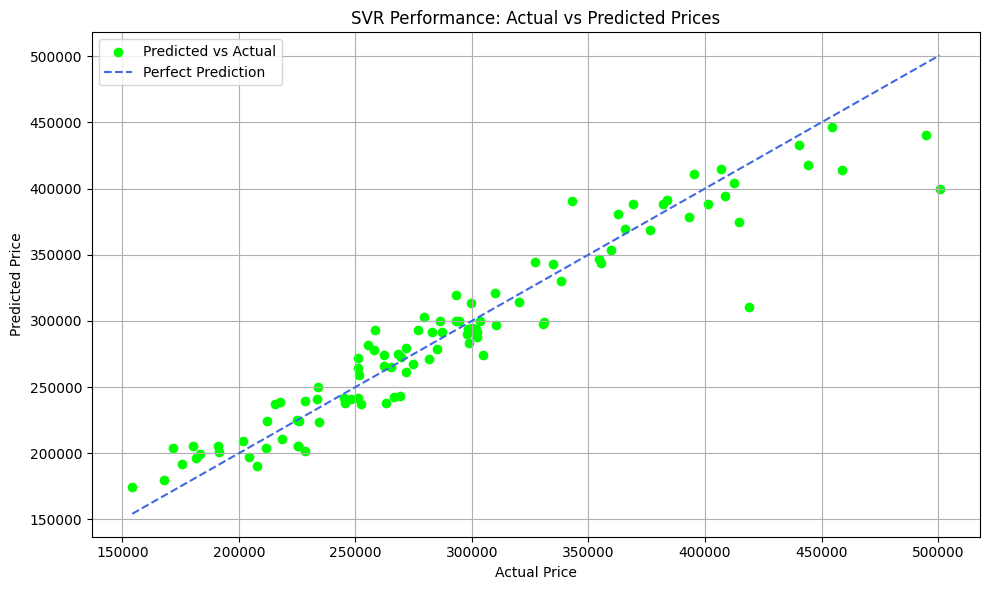

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on the training data
y_pred_scaled = regressor.predict(X)

# Inverse transform to get back to original price scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_actual = scaler_y.inverse_transform(np.array(y).reshape(-1, 1)).ravel()

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, y_pred, color='lime', label='Predicted vs Actual')
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='royalblue', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("SVR Performance: Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### CALCULATING MSE AND R2 SCORE FOR PERFORMANCE BENCHMARKS

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# Get predictions
y_pred_scaled = regressor.predict(X)

# Inverse scale to get actual prices
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = scaler_y.inverse_transform(y.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📏 Mean Squared Error (MSE): {mse:.2f}")
print(f"📊 R² Score: {r2:.4f}")


📏 Mean Squared Error (MSE): 531645521.82
📊 R² Score: 0.9095


### SERIALIZE THE MODEL AND TRANSFORMERS TO USE LATER

In [12]:
import pickle

# Save the trained SVR model
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(regressor, f)

# Save the scaler for X
with open('scaler_x.pkl', 'wb') as f:
    pickle.dump(scaler_x, f)

# Save the scaler for y
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

# Save the column transformer (for encoding the 'view' column)
with open('column_transformer.pkl', 'wb') as f:
    pickle.dump(column_transformer, f)

print("All components saved successfully!")


✅ Saved with joblib like a grown-up.
